In [51]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
from matplotlib.dates import date2num, num2date
from utide import solve, reconstruct
import numpy as np
import pandas as pd
from windrose import WindroseAxes
import scipy as sp
import hvplot.xarray
from eofs.xarray import Eof
import glob
import sklearn as skl
from sklearn.utils.extmath import randomized_svd
#import dask
from matplotlib import style
import EOF_funcs
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
import GA_cofine
from pyts.image import RecurrencePlot
from  importlib  import reload
import pywt
#from PyEMD import EMD, Visualisation
#import scaleogram as scg

## Reading the data, 
if surface.nc exists, read it, if not read the subset, select surface layer and replace NaN with interpolation in time. 

## Byfjorden
Change to 2 hours sampling period. 


In [352]:
filenm='Data/surface_.nc'
try:
    print('Read:'+filenm)
    surface=xr.open_dataset(filenm)
except:
    print('Cannot find:'+filenm)
    print('Creating...')
    data=xr.open_dataset('byfjordenSubset.nc')
    data.close()
    surface=data.isel(depth=0).sel(Y=slice(6733400,6737500),X=slice(-40000,-35000)).isel(depth=0)
    surface['u']=surface.u.interpolate_na(dim='time')
    surface['v']=surface.v.interpolate_na(dim='time')
    surface.to_netcdf(filenm)

min_time=pd.Timestamp(str(surface.time.min().data))
lngth=surface.time.sizes['time']

# Overwrite time to 2H 
surface['time']=pd.date_range(str(mint), freq="2H", periods=lngth)


Read:Data/surface_.nc


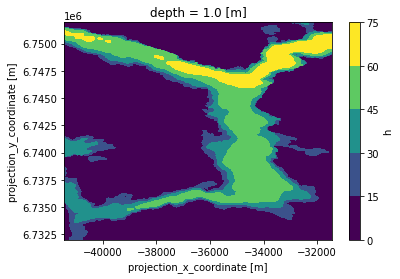

In [237]:
np.sqrt(10*surface.h).plot.contourf()

## Reading NS



In [229]:
import NS_velocity as rNS

data=rNS.read_month() 

Reading:  https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2022050100.nc
Reading:  https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2022050200.nc
Reading:  https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2022050300.nc
Reading:  https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2022050400.nc
Reading:  https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2022050500.nc
Reading:  https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2022050600.nc
Reading:  https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2022050700.nc
Reading:  https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2022050800.nc
Reading:  https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2022050900.nc
R

focusing

In [231]:
data.to_netcdf('Data/NS.nc')

## Some statistics

Text(0.5, 1.0, 'Standard deviation v velocity')

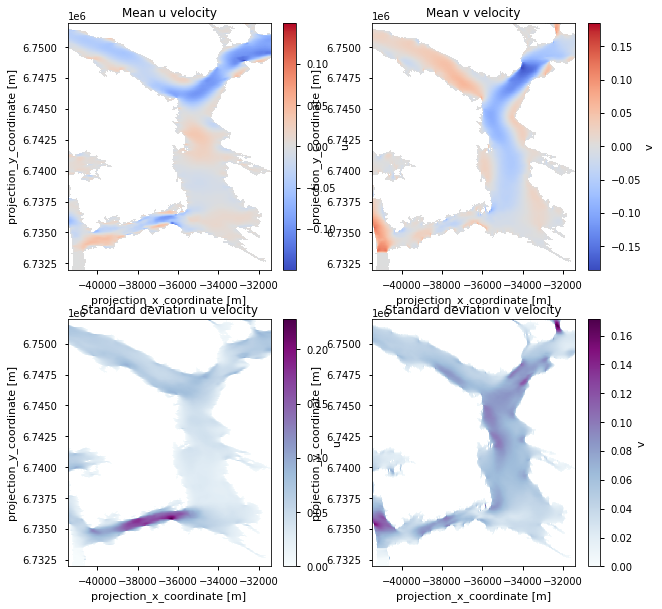

In [293]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
cmap='coolwarm'
cmap_std='BuPu'
surface.u.mean(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[0,0],cmap=cmap)
axes[0,0].set_title('Mean u velocity')
surface.v.mean(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[0,1],cmap=cmap)
axes[0,1].set_title('Mean v velocity')
surface.u.std(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[1,0],cmap=cmap_std)
axes[1,0].set_title('Standard deviation u velocity')
surface.v.std(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[1,1],cmap=cmap_std)
axes[1,1].set_title('Standard deviation v velocity')


Text(0.5, 1.0, 'Correlation u and v')

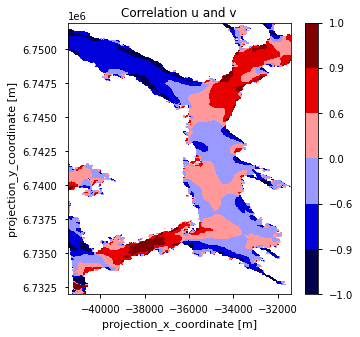

In [294]:
fig, axes = plt.subplots(ncols=1, figsize=(5,5))
xr.corr(surface.u,surface.v,dim='time').plot(vmin=-1,vmax=1,levels=[-1,-0.9,-0.6,0,0.6,0.9,1],cmap='seismic',ax=axes)
axes.set_title('Correlation u and v')


Focusing, jump over if not. 

In [295]:
surface=surface.sel(Y=slice(6733400,6737500),X=slice(-40000,-35000))

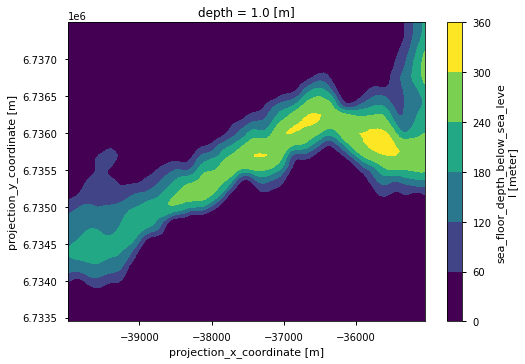

In [296]:
surface.h.plot.contourf()

Text(0.5, 1.0, 'Correlation u and v')

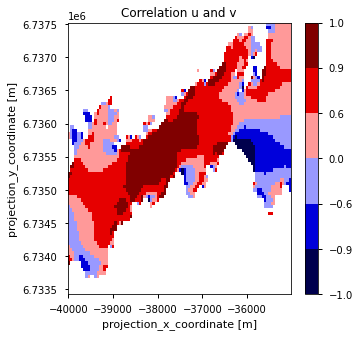

In [297]:
fig, axes = plt.subplots(ncols=1, figsize=(5,5))
xr.corr(surface.u,surface.v,dim='time').plot(vmin=-1,vmax=1,levels=[-1,-0.9,-0.6,0,0.6,0.9,1],cmap='seismic',ax=axes)
axes.set_title('Correlation u and v')


## Extract UV

In [353]:
uv=xr.Dataset()
uv['u']=surface.u
uv['v']=surface.v
uv=uv.stack(z=['Y','X'])


mask=surface.land_binary_mask.stack(z=['Y','X']).data
uv=uv.where(mask==0).dropna(dim='z')
#v=v.where(mask==0).dropna(dim='z')

In [354]:
uv

<xarray.Dataset>
Dimensions:  (time: 1501, z: 28375)
Coordinates:
    depth    float32 ...
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-30T16:00:00
  * z        (z) MultiIndex
  - Y        (z) float64 6.732e+06 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X        (z) float64 -4.124e+04 -4.119e+04 ... -3.219e+04 -3.214e+04
Data variables:
    u        (time, z) float32 0.0 0.0 0.0 0.0 ... -0.04241 -0.02036 -0.003527
    v        (time, z) float32 0.0 0.0 0.0 0.0 ... 0.1071 0.089 0.06619 0.02443

## Tidal analysis of raw uv

In [355]:
print(uv.sizes['z'])

28375


In [356]:
uv['tide_u']=uv.u*0
uv['tide_v']=uv.v*0
for z in range(uv.sizes['z']):
    signal1=uv.u.isel(z=z)
    signal2=uv.v.isel(z=z)
    coef = solve(date2num(signal1.time), signal1.data,signal2.data, lat=60.0,verbose=False)#, constit=['M2'])#,nodal=True, rend=True, method='robust', conf_int='linear', Rayleigh_min=0.95)

    tide = reconstruct(date2num(signal.time), coef,verbose=False)   

    uv['tide_u'][:,z]=tide.u
    uv['tide_v'][:,z]=tide.v

/Users/guttorm/Documents/GitHub/FACTS/venv/lib/python3.8/site-packages/utide/confidence.py:250: RuntimeWarning: invalid value encountered in double_scalars
  varXv = Pvv[c] * varXv / den
/Users/guttorm/Documents/GitHub/FACTS/venv/lib/python3.8/site-packages/utide/confidence.py:251: RuntimeWarning: invalid value encountered in double_scalars
  varYv = Pvv[c] * varYv / den
/Users/guttorm/Documents/GitHub/FACTS/venv/lib/python3.8/site-packages/utide/diagnostics.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  PE = (100 / np.sum(E)) * E
/Users/guttorm/Documents/GitHub/FACTS/venv/lib/python3.8/site-packages/utide/diagnostics.py:10: RuntimeWarning: invalid value encountered in multiply
  PE = (100 / np.sum(E)) * E
/Users/guttorm/Documents/GitHub/FACTS/venv/lib/python3.8/site-packages/utide/_reconstruct.py:110: RuntimeWarning: invalid value encountered in true_divide
  PE = 100 * E / E.sum()
/Users/guttorm/Documents/GitHub/FACTS/venv/lib/python3.8/site-packages/utide/conf

In [360]:
uv.unstack('z').to_netcdf('Data/tide.nc')

In [491]:
uv['u'].isel(time=348).max()

<xarray.DataArray 'u' ()>
array(0.31923008, dtype=float32)
Coordinates:
    depth    float32 1.0
    time     datetime64[ns] 2010-04-25T16:00:00

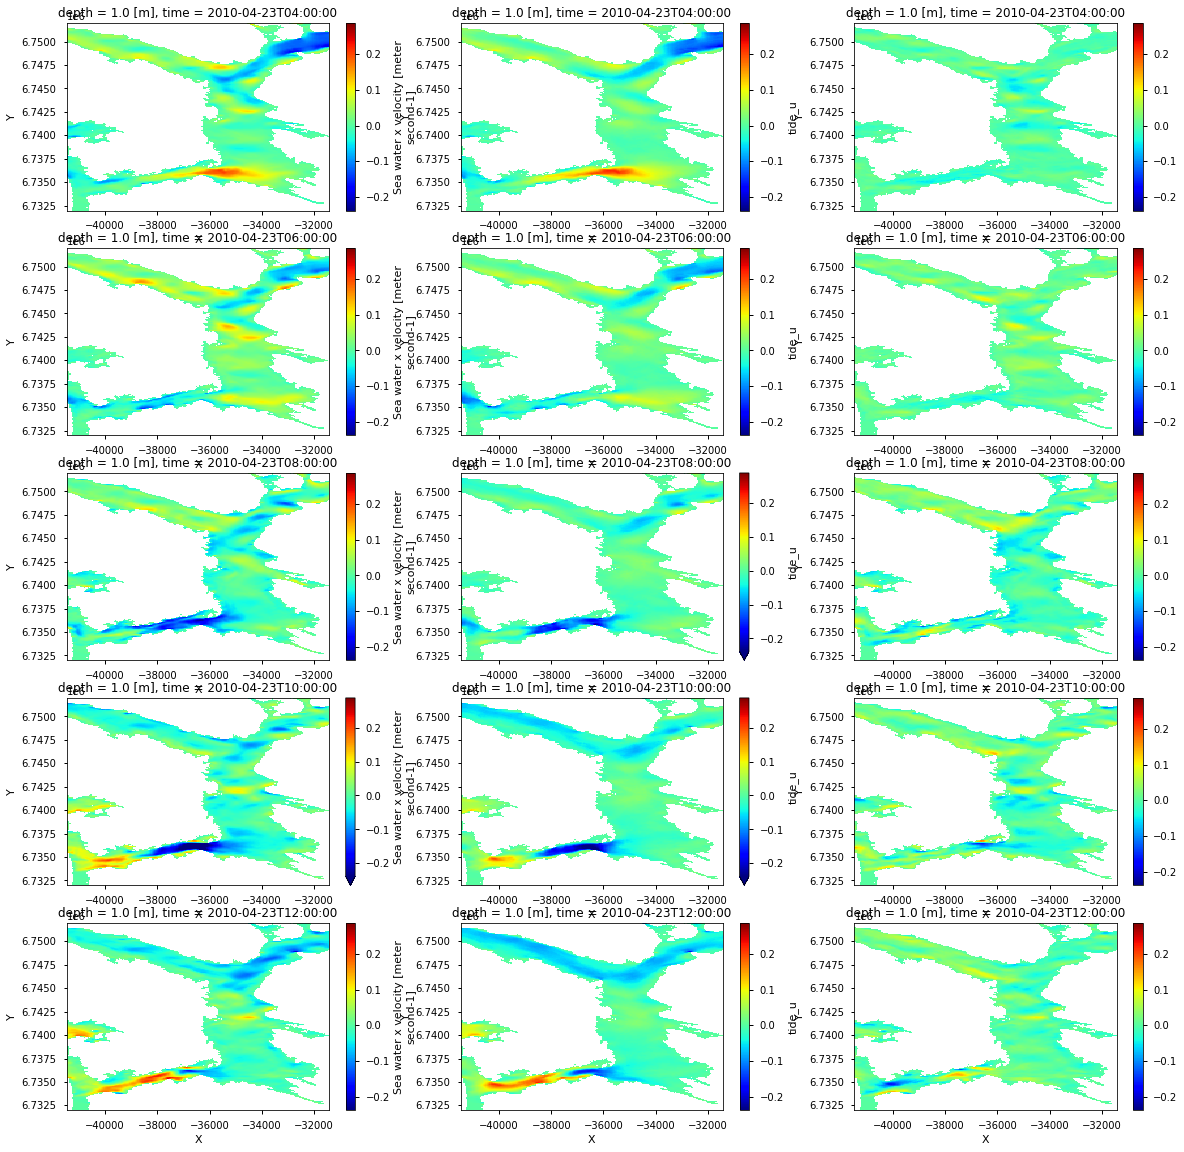

In [612]:
time=318

nrows=5
comp='u'
vmax=0.9*uv[comp].isel(time=348).max().data
vmin=0.9*uv[comp].isel(time=348).min().data
cmap='jet'
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(20,20))
for row in range(nrows):
    uv[comp].isel(time=time+row).unstack('z').plot(ax=axes[row,0],vmax=vmax,vmin=vmin,cmap=cmap)
    uv['tide_'+comp].isel(time=time+row).unstack('z').plot(ax=axes[row,1],vmax=vmax,vmin=vmin,cmap=cmap)
    (uv[comp]-uv['tide_'+comp]).isel(time=time+row).unstack('z').plot(ax=axes[row,2],vmax=vmax,vmin=vmin,cmap=cmap)

/Users/guttorm/Documents/GitHub/FACTS/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


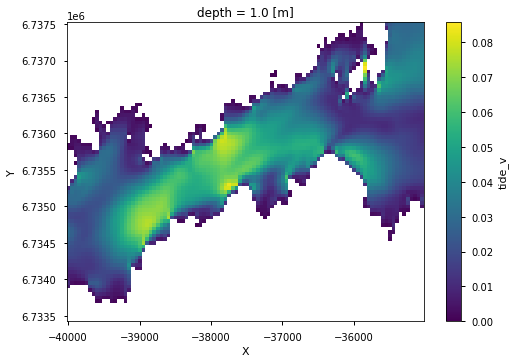

In [608]:
#sel(Y=slice(6733400,6737500),X=slice(-40000,-35000))
X=-35500
Y=6745000
uv.unstack('z').sel(Y=slice(6733400,6737500),X=slice(-40000,-35000)).tide_v.std(dim='time').plot()

In [625]:
help(uv.argmax)

Help on method argmax in module xarray.core.dataset:

argmax(dim=None, **kwargs) method of xarray.core.dataset.Dataset instance
    Indices of the maxima of the member variables.
    
    If there are multiple maxima, the indices of the first one found will be
    returned.
    
    Parameters
    ----------
    dim : str, optional
        The dimension over which to find the maximum. By default, finds maximum over
        all dimensions - for now returning an int for backward compatibility, but
        this is deprecated, in future will be an error, since DataArray.argmax will
        return a dict with indices for all dimensions, which does not make sense for
        a Dataset.
    keep_attrs : bool, optional
        If True, the attributes (`attrs`) will be copied from the original
        object to the new one.  If False (default), the new object will be
        returned without attributes.
    skipna : bool, optional
        If True, skip missing values (as marked by NaN). By defa

## Raw correlation plots





In [474]:
uv

<xarray.Dataset>
Dimensions:  (time: 1501, z: 28375)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-30T16:00:00
  * z        (z) MultiIndex
  - Y        (z) float64 6.732e+06 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X        (z) float64 -4.124e+04 -4.119e+04 ... -3.219e+04 -3.214e+04
Data variables:
    u        (time, z) float32 0.0 0.0 0.0 0.0 ... -0.04241 -0.02036 -0.003527
    v        (time, z) float32 0.0 0.0 0.0 0.0 ... 0.1071 0.089 0.06619 0.02443
    tide_u   (time, z) float32 0.0 0.0 0.0 0.0 ... -0.001441 0.003429 0.000571
    tide_v   (time, z) float32 0.0 0.0 0.0 0.0 ... 0.01527 0.02061 0.01084

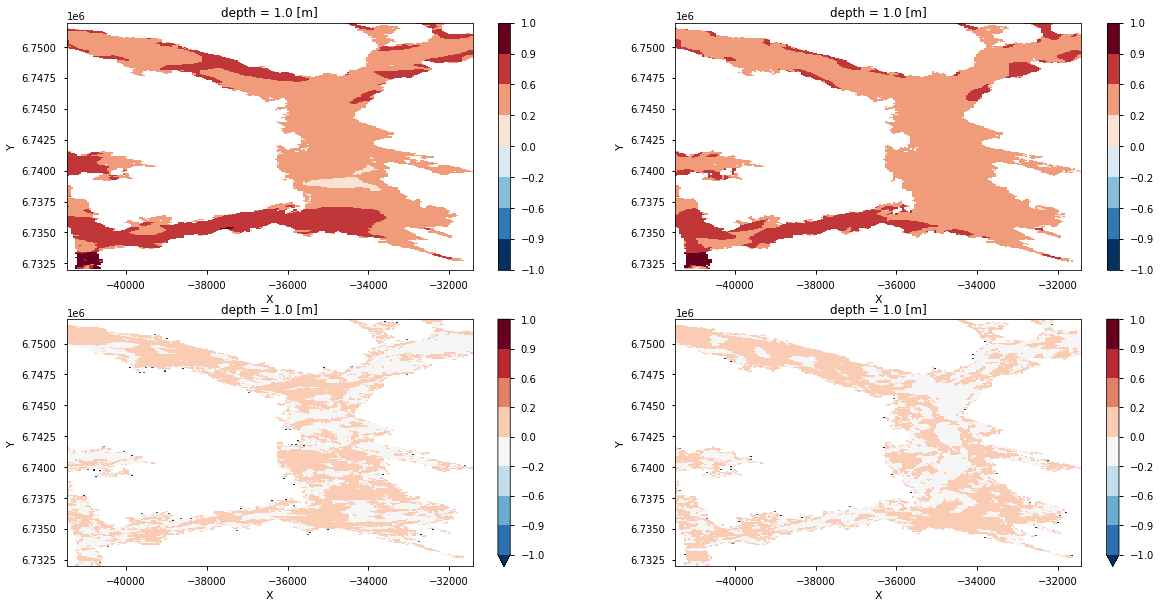

In [477]:

fig,axes=plt.subplots(ncols=2,nrows=2,figsize=(20,10))
levels=[-1,-0.9,-0.6,-0.2,0,0.2,0.6,0.9,1]
xr.corr(uv.tide_u,uv.u,dim='time').unstack('z').plot(ax=axes[0,0],levels=levels)
xr.corr(uv.tide_v,uv.v,dim='time').unstack('z').plot(ax=axes[0,1],levels=levels)
xr.corr(uv.tide_u,uv.u-uv.tide_u,dim='time').unstack('z').plot(ax=axes[1,0],levels=levels)
xr.corr(uv.tide_v,uv.v-uv.tide_v,dim='time').unstack('z').plot(ax=axes[1,1],levels=levels)

## EOF analysis

* First centralize the velocity components, i.e. subtract mean in time at each point, 
* stack the spatial coordinates.
* create mask based on *land_binary_mask*
* delete land points


Create the covariance matrix

$$ C = P^T S
$$

where $P$ and $S$ contains, respectively, the u and v time series 

Here N and *randomstate* is only used if we use randomized_svd in the next step. 

In [495]:
P=uv.u-uv.tide_u
P=(P-P.mean(dim='time'))

S=uv.v-uv.tide_v
S=(S-S.mean(dim='time'))

mask=surface.land_binary_mask.stack(z=['Y','X']).data

In [496]:
C=P.data.T@S.data
N=20
random_state=0

Do the SVD analysis.

In [497]:
U,L,Vt=randomized_svd(C,N,random_state=random_state)#np.linalg.svd(C)#randomized_svd(C,N,random_state=random_state)

Calculate the principal components 
$$ A = P U \\ B= S V$$

In [498]:
A=P.data@U
B=S.data@Vt.T

Put all into a xarray

In [499]:
res=xr.Dataset(coords=P.coords)

res['U']=(('z','mode'),U)
res['V']=(('z','mode'),Vt.T)
res['L']=(('mode'),L)
res['A']=(('time','mode'),A)
res['B']=(('time','mode'),B)
res

<xarray.Dataset>
Dimensions:  (time: 1501, z: 28375, mode: 20)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-30T16:00:00
  * z        (z) MultiIndex
  - Y        (z) float64 6.732e+06 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X        (z) float64 -4.124e+04 -4.119e+04 ... -3.219e+04 -3.214e+04
Dimensions without coordinates: mode
Data variables:
    U        (z, mode) float32 4.555e-13 -5.589e-08 ... 0.0009696 -0.001169
    V        (z, mode) float32 -5.176e-13 3.332e-07 ... 0.005165 -0.003641
    L        (mode) float32 2.551e+04 1.046e+04 3.57e+03 ... 408.7 373.0 355.0
    A        (time, mode) float32 2.438 -0.7947 -1.312 ... 0.8169 -0.1552 0.4032
    B        (time, mode) float32 2.213 -1.57 -2.032 ... 0.9694 -0.7281 0.4507

### The singular values

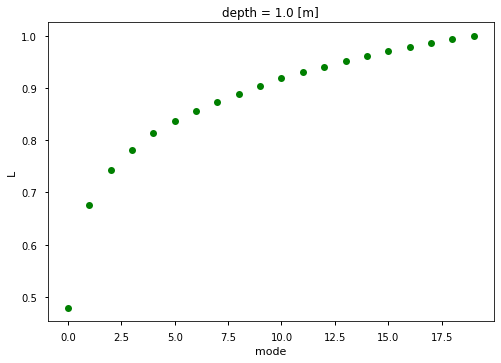

In [506]:
(res.L.cumsum()/res.L.sum()).plot.line('go')

(0.0, 20.0)

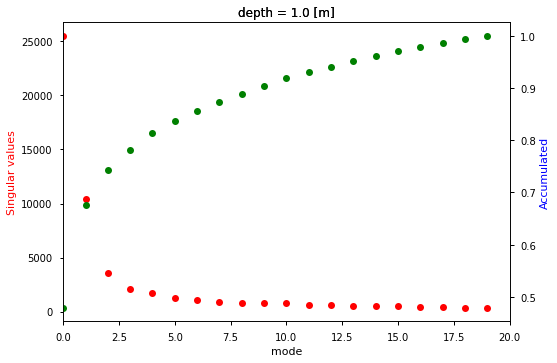

In [507]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
res.L.plot.line('ro',ax=ax1)
(res.L.cumsum()/res.L.sum()).plot.line('go',ax=ax2)
ax2.set_ylabel('Accumulated', color='b')
ax1.set_ylabel('Singular values', color='r')
plt.xlim(0,20)


Keeping 20 modes. Calculate reconstructed fields and put the original fields into *res*. 

In [508]:
res=res.isel(mode=slice(0,20))
res['usvd']=(('time','z'),res.A.data@res.U.data.T)
res['vsvd']=(('time','z'),res.B.data@res.V.data.T)
res['u']=P
res['v']=S
res=res.drop('depth')

Can look at the results. 

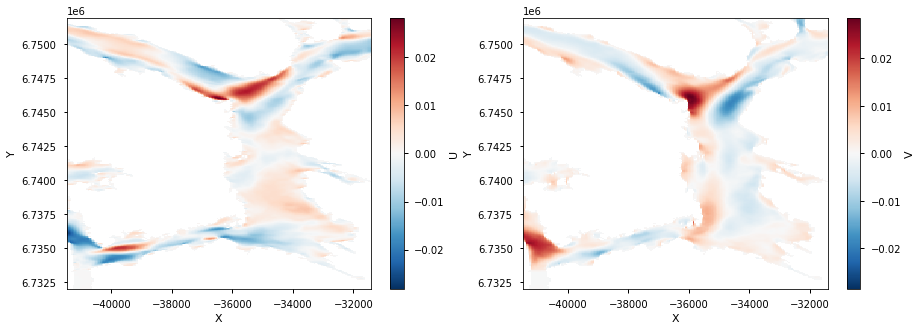

In [514]:
mode=4
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

res.U.isel(mode=mode).unstack('z').plot(ax=axes[0])
res.V.isel(mode=mode).unstack('z').plot(ax=axes[1])


At specific times.

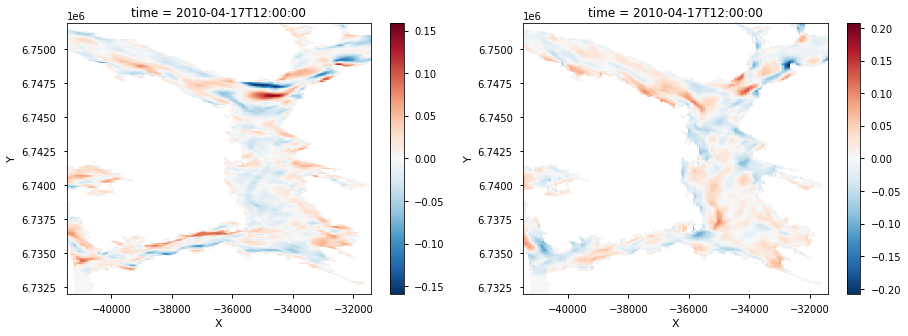

In [515]:
time=250
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

(res.usvd-res.u).isel(time=time).unstack('z').plot(ax=axes[0])
(res.vsvd-res.v).isel(time=time).unstack('z').plot(ax=axes[1])

Statistics.

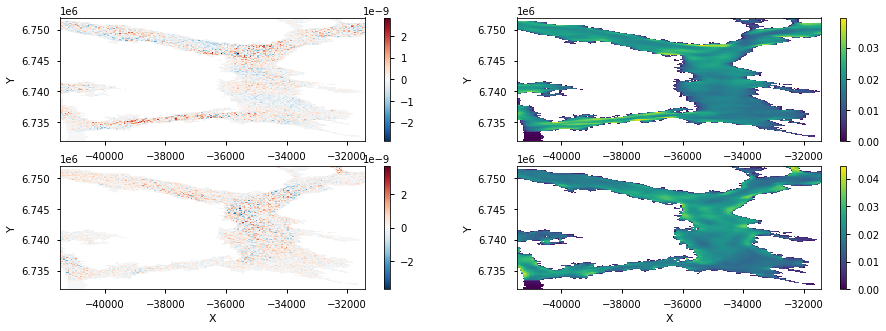

In [516]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,5))
(res.usvd-res.u).mean(dim='time').unstack('z').plot(ax=axes[0,0])
(res.usvd-res.u).std(dim='time').unstack('z').plot(ax=axes[0,1])
(res.vsvd-res.v).mean(dim='time').unstack('z').plot(ax=axes[1,0])
(res.vsvd-res.v).std(dim='time').unstack('z').plot(ax=axes[1,1])

In [68]:
res[['A','B','U','V','L']].unstack('z').to_netcdf('test.nc')

In [69]:
res[['u','v']].unstack('z').to_netcdf('testu.nc')

In [112]:
res=res.isel(mode=np.arange(0,20))

## Correlation plots

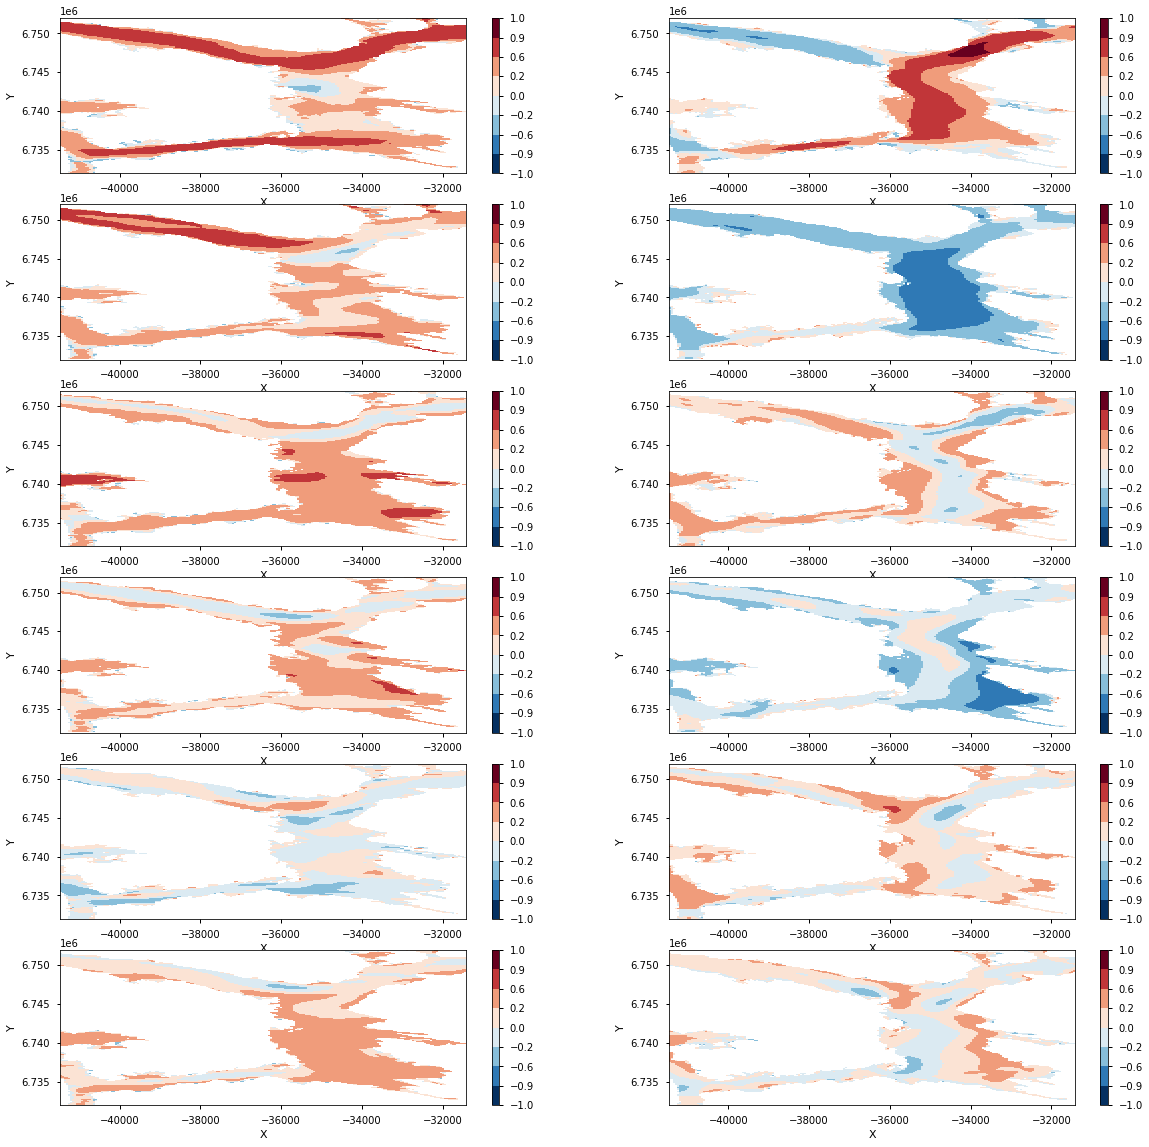

In [517]:
nmodes=6
modes=np.arange(0,nmodes)
tmp=res.isel(mode=0)
fig,axes=plt.subplots(ncols=2,nrows=nmodes,figsize=(20,20))
levels=[-1,-0.9,-0.6,-0.2,0,0.2,0.6,0.9,1]
for mode in modes:
    tmp=res.isel(mode=mode)
    xr.corr(tmp.A,tmp.u,dim='time').unstack('z').plot(ax=axes[mode,0],levels=levels)
    xr.corr(tmp.B,tmp.v,dim='time').unstack('z').plot(ax=axes[mode,1],levels=levels)


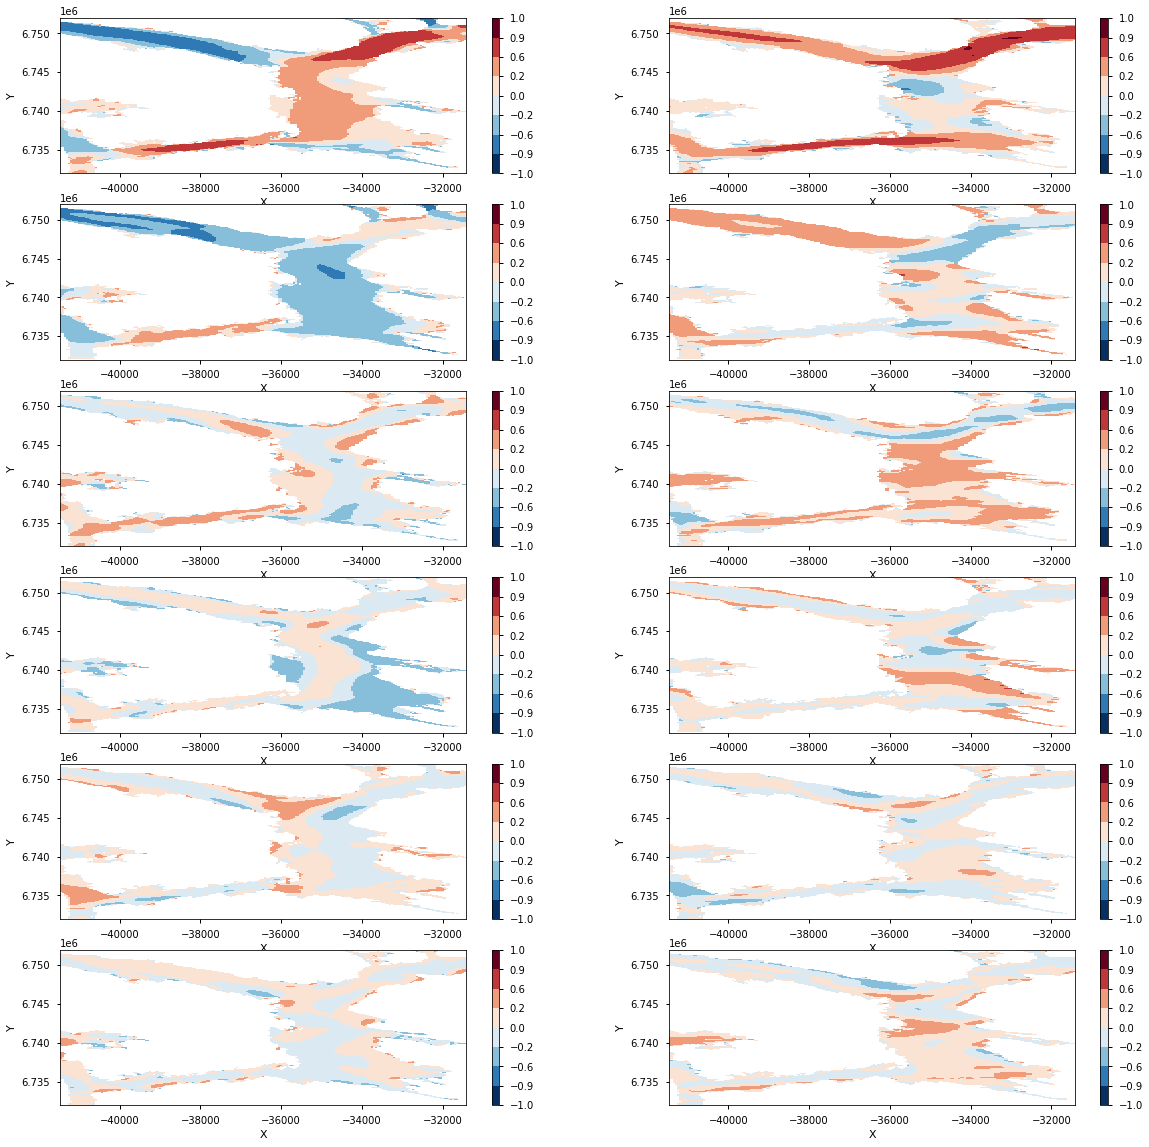

In [449]:
nmodes=6
modes=np.arange(0,nmodes)
tmp=res.isel(mode=0)
fig,axes=plt.subplots(ncols=2,nrows=nmodes,figsize=(20,20))
levels=[-1,-0.9,-0.6,-0.2,0,0.2,0.6,0.9,1]
for mode in modes:
    tmp=res.isel(mode=mode)
    xr.corr(tmp.A,tmp.v,dim='time').unstack('z').plot(ax=axes[mode,0],levels=levels)
    xr.corr(tmp.B,tmp.u,dim='time').unstack('z').plot(ax=axes[mode,1],levels=levels)

## Time series
Focus on the time variability. Resample to a period of 1 hour. 

In [518]:
res.time

<xarray.DataArray 'time' (time: 1501)>
array(['2010-03-27T16:00:00.000000000', '2010-03-27T18:00:00.000000000',
       '2010-03-27T20:00:00.000000000', ..., '2010-07-30T12:00:00.000000000',
       '2010-07-30T14:00:00.000000000', '2010-07-30T16:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-30T16:00:00

In [519]:
pcs=res[['A','B']]
#pcs['time']=res.time.resample(time='2H').mean()

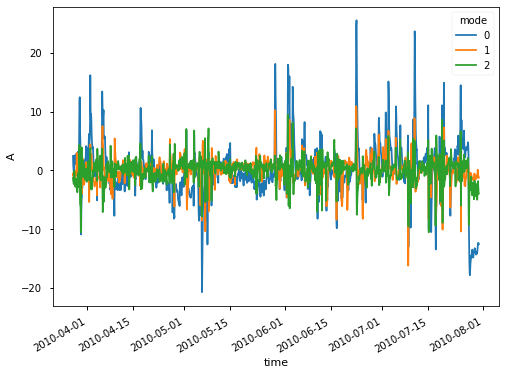

In [524]:
pcs.isel(mode=slice(0,3)).A.plot.line(x='time')

###  Scatter plots

The modes are uncorrelated, however *A* and *B* are correlated for the same *mode*

<AxesSubplot:xlabel='A', ylabel='A'>

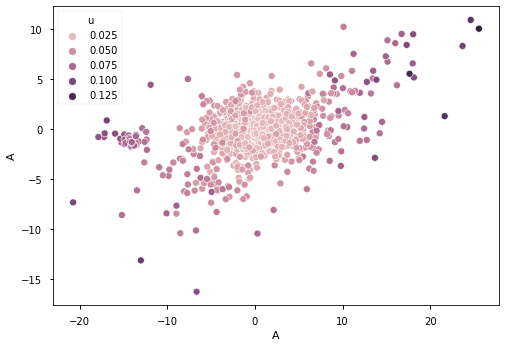

In [528]:
mode1=0
mode2=1
sns.scatterplot(x=res.A.isel(mode=mode1),y=res.A.isel(mode=mode2),hue=res.u.std('z'))

### autocorrelation

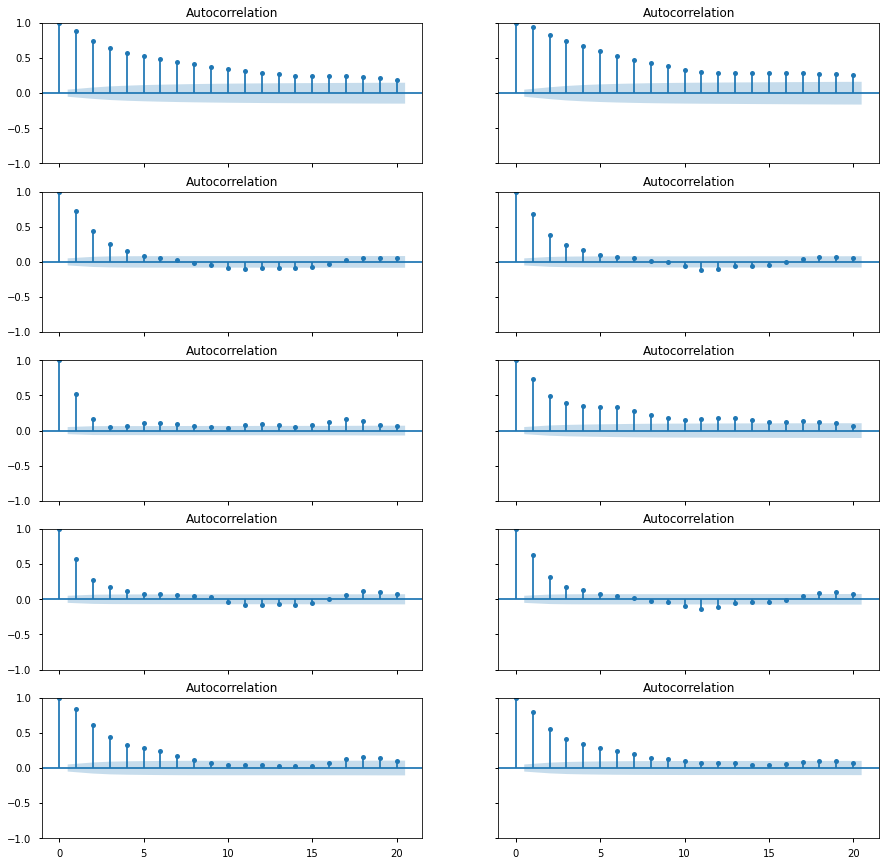

In [529]:
rows=5
lags=20
levels=[-1,-0.9,-0.7,-0.5,-0.3,0,0.3,0.5,0.7,0.9,1]
cmap='coolwarm'
fig, axes = plt.subplots(ncols=2, nrows=rows, figsize=(15,15),sharex=True,sharey=True)

for ii in np.arange(rows):
    plot_acf(pcs.A.isel(mode=ii).data,lags=lags,ax=axes[ii,0])
    plot_acf(pcs.B.isel(mode=ii).data,lags=lags,ax=axes[ii,1])

## Utide


In [454]:
mode=2
signal1=pcs.A.isel(mode=mode)
signal2=pcs.B.isel(mode=mode)
coef = solve(date2num(signal.time), signal1.data,signal2.data, lat=60.0)#, constit=['M2'])#,nodal=True, rend=True, method='robust', conf_int='linear', Rayleigh_min=0.95)

tide = reconstruct(date2num(signal.time), coef)

#coef

solve: matrix prep ... solution ... done.
prep/calcs ... done.


Text(0.5, 1.0, 'Residue')

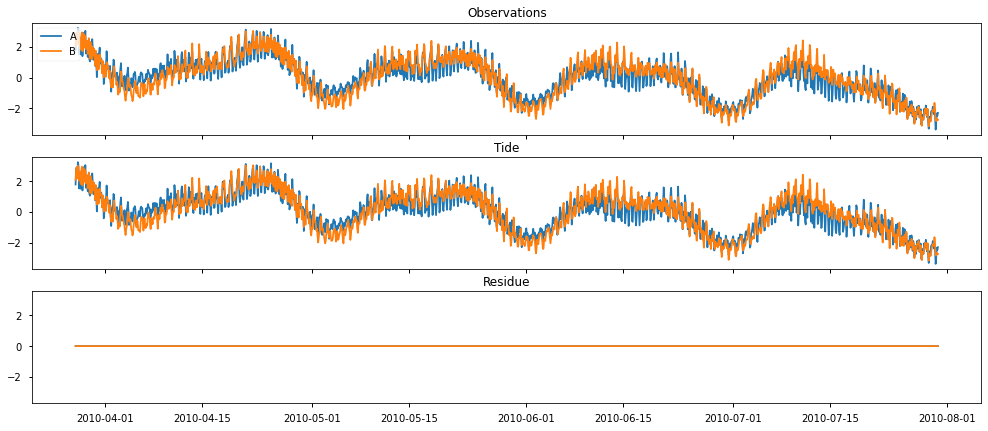

In [455]:
from matplotlib import style

style.use('seaborn-notebook')
t=signal.time
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True,  figsize=(17, 7))

ax0.plot(t, signal1, label='A')
ax0.plot(t, signal2, label='B')

ax0.legend(numpoints=1, loc='upper left')
ax0.set_title('Observations')


ax1.plot(t, tide['u'] )
ax1.plot(t, tide['v'])
ax1.set_title('Tide')
#ax1.legend(numpoints=1, loc='upper left')

ax2.plot(t, signal1-tide['u'])
ax2.plot(t, signal2-tide['v'])
ax2.set_title('Residue')

In [278]:
tmp=plot_acf(signal.data-tide.h,lags=24)

AttributeError: 'Bunch' object has no attribute 'h'

## FFT

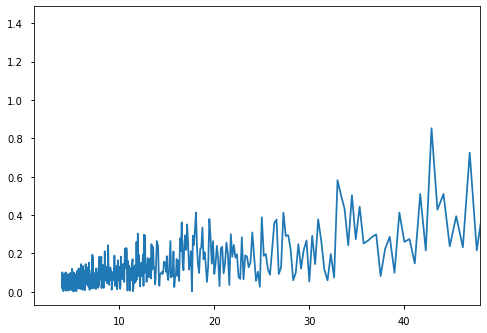

In [531]:
from scipy.fft import fft, fftfreq
modes=[0]
for ii in modes:
    signal =pcs.A.isel(mode=ii)
    N=np.size(signal)
    T=2#((signal.time[-1]-signal.time[0])/np.timedelta64(1, 'h')).data
    y=fft(signal.data)
    y=2.0/N * np.abs(y[0:N//2-1])
    x=(fftfreq(N, T)[:N//2-1])
    x=1/(x+1e-9)
    plt.plot(x,y)
    plt.xlim(1,48)

(5.0, 36.0)

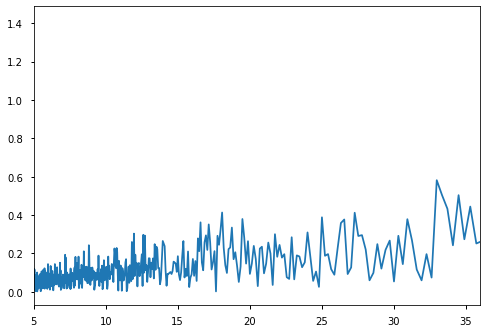

In [532]:
pks,_=sp.signal.find_peaks(y,height=0.12)


plt.plot(x,y)
plt.plot(x[pks],y[pks],'x')
plt.xlim(5,36)

In [458]:
x[pks]

array([3001.99098802,  600.39963952,  333.5554443 ,   26.80357071,
         25.87930968,   21.59712184,   13.10917013,   12.66666651,
         12.40495852,   12.15384601,   12.00799986,   11.77254888,
          6.26722334,    6.21532087,    6.10162598])

### Continuous Wavelet

In [533]:
pywt.frequency2scale('cmor-0.5-5.0',1)

5.0

In [534]:
ts.time

<xarray.DataArray 'time' (time: 1501)>
array(['2010-03-27T16:00:00.000000000', '2010-03-27T18:00:00.000000000',
       '2010-03-27T20:00:00.000000000', ..., '2010-07-30T12:00:00.000000000',
       '2010-07-30T14:00:00.000000000', '2010-07-30T16:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-30T16:00:00
Attributes:
    long_name:      time since initialization
    field:          time, scalar, series
    axis:           T
    standard_name:  time

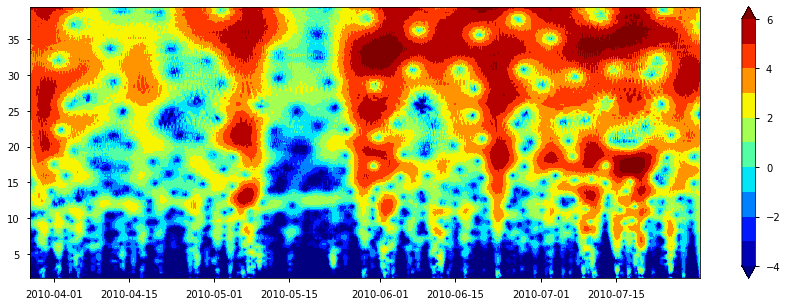

In [535]:
ts=pcs.A.sel(mode=0)#.isel(time=slice(100,164))

wavelet = 'cmor-0.5-5.0'
minscale=pywt.frequency2scale(wavelet,10)
maxscale=pywt.frequency2scale(wavelet,0.05)

scales = np.arange(4, 100)

[cfs, freq]=pywt.cwt(ts.data,scales, wavelet)#,dt)
power=np.abs(cfs)**2
period=2/freq
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16,32,64]


f, ax = plt.subplots(figsize=(15, 5))
plt.contourf(ts.time.data, period, np.log2(power[:,:]), np.log2(levels),cmap = plt.cm.jet,extend='both')#,vmax=4)
#plt.ylim(0,24)
plt.colorbar()

## Filter

(100.0, 224.0)

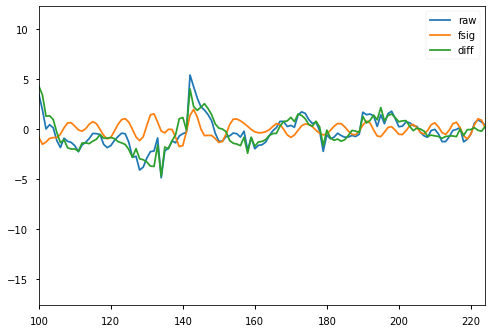

In [536]:
import statsmodels.api as sm
signal =pcs.A.isel(mode=1)
fsig=sm.tsa.filters.bkfilter(signal,low=5,high=15)
plt.plot(signal[12:-12],label='raw')
plt.plot(fsig, label='fsig')

plt.plot(signal[12:-12]-fsig,label='diff')
plt.legend()
plt.xlim(100,224)

(0.0, 300.0)

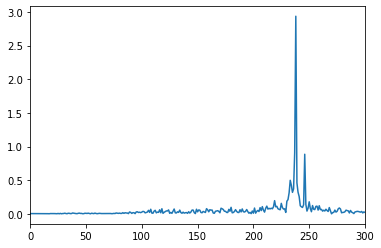

In [173]:
plt.plot(2.0/N * np.abs(fft(fsig)[0:N//2-1]))
plt.xlim(0,300)

(0.0, 300.0)

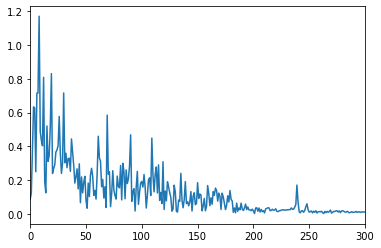

In [118]:
plt.plot(2.0/N * np.abs(fft((signal[12:-12]-fsig).data)[0:N//2-1]))
plt.xlim(0,300)

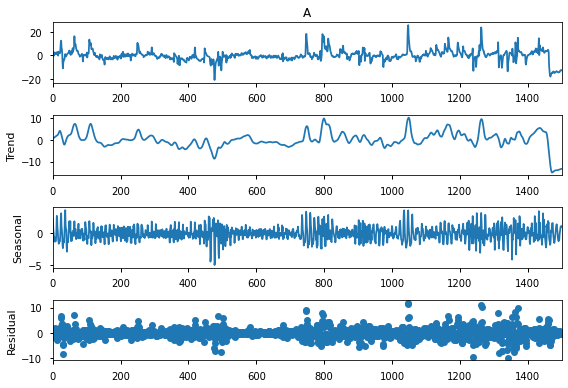

In [537]:
from statsmodels.tsa.seasonal import STL
ts=pcs.A.sel(mode=0)
res=STL(ts,period=12).fit()
fig=res.plot()
#fig.set_xlim(200,224)

In [85]:
res.trend



array([  1.5835539 ,   1.51079821,   1.44007074, ..., -10.06101184,
        -9.96689485,  -9.87190991])

In [179]:
from statsmodels.tsa.seasonal import seasonal_decompose
period=11
decomp=pcs.copy()
decomp['A_trend']=xr.zeros_like(decomp['A'])
decomp['A_seas']=xr.zeros_like(decomp['A'])
decomp['A_resid']=xr.zeros_like(decomp['A'])
decomp['B_trend']=xr.zeros_like(decomp['B'])
decomp['B_seas']=xr.zeros_like(decomp['B'])
decomp['B_resid']=xr.zeros_like(decomp['B'])
#decomp['A_trend'].loc[dict(mode=0)]=seas.trend
#decomp.A_trend.isel(mode=0)

for mode in pcs.mode:
    tmpA=STL(pcs.A.isel(mode=mode).data, period=period).fit()
    decomp['A_trend'].loc[dict(mode=mode)]=tmpA.trend
    decomp['A_seas'].loc[dict(mode=mode)]=tmpA.seasonal
    decomp['A_resid'].loc[dict(mode=mode)]=tmpA.resid
    tmpB=STL(pcs.A.isel(mode=mode).data, period=period).fit()
    decomp['B_trend'].loc[dict(mode=mode)]=tmpB.trend
    decomp['B_seas'].loc[dict(mode=mode)]=tmpB.seasonal
    decomp['B_resid'].loc[dict(mode=mode)]=tmpB.resid

In [180]:
decomp

<xarray.Dataset>
Dimensions:  (time: 1501, mode: 20)
Coordinates:
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-30T16:00:00
Dimensions without coordinates: mode
Data variables:
    A        (time, mode) float32 10.65 -2.288 0.1283 ... -0.6409 0.3932 0.2048
    B        (time, mode) float32 4.159 -0.7982 0.2008 ... -0.3278 0.5156 0.4159
    A_trend  (time, mode) float32 1.382 -2.098 -0.6244 ... 0.405 -0.006085
    A_seas   (time, mode) float32 2.841 2.403 0.1997 ... 0.07883 0.1701 0.3851
    A_resid  (time, mode) float32 6.426 -2.594 0.553 ... -0.1819 -0.1742
    B_trend  (time, mode) float32 1.382 -2.098 -0.6244 ... 0.405 -0.006085
    B_seas   (time, mode) float32 2.841 2.403 0.1997 ... 0.07883 0.1701 0.3851
    B_resid  (time, mode) float32 6.426 -2.594 0.553 ... -0.1819 -0.1742

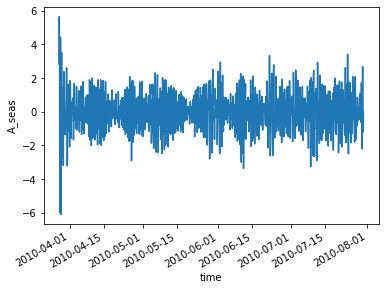

In [181]:
decomp.A_seas.isel(mode=0).plot()

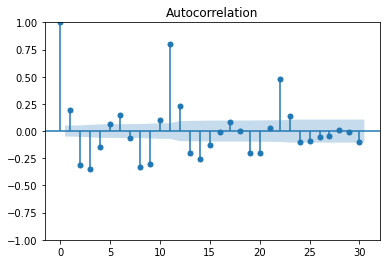

In [182]:
fig=plot_acf(decomp.A_seas.dropna(dim='time').isel(mode=3),lags=30)

In [92]:
decomp

<xarray.Dataset>
Dimensions:  (time: 2667, mode: 20)
Coordinates:
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:00:00
Dimensions without coordinates: mode
Data variables:
    A        (time, mode) float64 10.65 -2.288 0.1283 ... -0.544 0.3785 -0.05084
    B        (time, mode) float64 4.159 -0.7982 0.2008 ... 0.3662 0.05784
    A_trend  (time, mode) float64 1.584 -0.06949 -0.5833 ... 0.501 0.2302
    A_seas   (time, mode) float64 8.581 -1.895 0.6604 ... -0.1851 -0.3078
    A_resid  (time, mode) float64 0.4854 -0.3237 0.05127 ... 0.06262 0.02684
    B_trend  (time, mode) float64 1.584 -0.06949 -0.5833 ... 0.501 0.2302
    B_seas   (time, mode) float64 8.581 -1.895 0.6604 ... -0.1851 -0.3078
    B_resid  (time, mode) float64 0.4854 -0.3237 0.05127 ... 0.06262 0.02684

In [538]:
pcs

<xarray.Dataset>
Dimensions:  (time: 1501, mode: 20)
Coordinates:
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-30T16:00:00
Dimensions without coordinates: mode
Data variables:
    A        (time, mode) float32 2.438 -0.7947 -1.312 ... 0.8169 -0.1552 0.4032
    B        (time, mode) float32 2.213 -1.57 -2.032 ... 0.9694 -0.7281 0.4507

<AxesSubplot:>

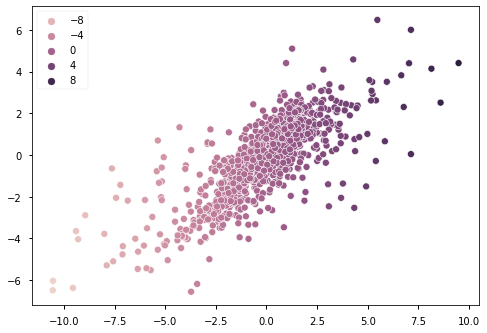

In [548]:
mode=2
x=pcs.A.isel(mode=mode).data
y=pcs.B.isel(mode=mode).data
hue=pcs.A.isel(mode=mode).data
sns.scatterplot(x=x,y=y,hue=hue)

In [541]:
keys=list(pcs.data_vars)
keys

['A', 'B']

In [542]:
mat=[]
for key in keys:
    mat.append(decomp[key].rename('val'))

mat=xr.concat(mat,'num')
mat=mat.stack(z=['num','mode'])


In [549]:
mat=pcs.A.data

In [550]:
np.shape(mat.data)

(1501, 20)

In [551]:
import hdbscan

clust= hdbscan.HDBSCAN()
clust.fit(mat)

HDBSCAN()

In [552]:
np.unique(clust.labels_)

array([-1,  0,  1])

<AxesSubplot:>

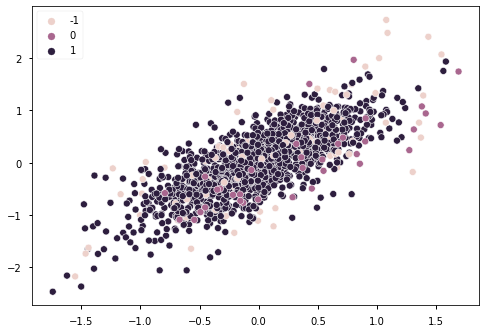

In [564]:
mode=18
x=pcs.A.isel(mode=mode).data
y=pcs.B.isel(mode=mode).data
hue=clust.labels_
sns.scatterplot(x=x,y=y,hue=hue)

In [229]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
#matrix= StandardScaler().fit_transform(matrix)
db = DBSCAN(eps=5, min_samples=3).fit(mat.data)

In [242]:
sns.scatterplot(x=decomp.A.data,y=decomp.B.data,hue=clust.labels_)

ValueError: Data must be 1-dimensional

In [239]:
db=clust

In [241]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
# print(
#     "Adjusted Mutual Information: %0.3f"
#     % metrics.adjusted_mutual_info_score(labels_true, labels)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(mat, labels))
labels

Estimated number of clusters: 2
Estimated number of noise points: 19
Silhouette Coefficient: 0.406


array([0, 0, 0, ..., 1, 1, 1])

In [231]:
Counter(labels).most_common()

[(0, 2512),
 (-1, 66),
 (8, 63),
 (2, 7),
 (6, 4),
 (1, 3),
 (3, 3),
 (4, 3),
 (5, 3),
 (7, 3)]

## EMD

In [215]:
emd = EMD()
emd.emd(ts.data, ts.time)
imfs, resid = emd.get_imfs_and_residue()

UFuncTypeError: ufunc 'true_divide' cannot use operands with types dtype('float64') and dtype('<m8[ns]')

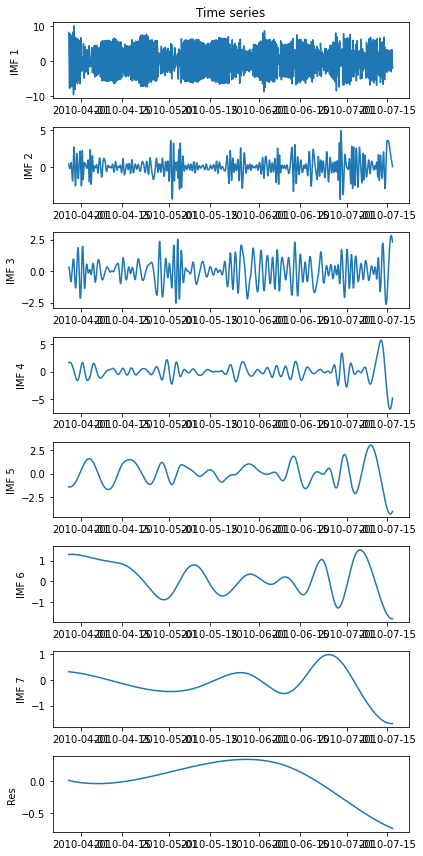

In [216]:
vis = Visualisation()
vis.plot_imfs(imfs=imfs, residue=resid, t=ts.time, include_residue=True)
vis.plot_instant_freq(ts.time, imfs=imfs)
vis.show()

## SSA

In [569]:
mode=0
ts=pcs.A.isel(mode=mode)

In [570]:
from pyts.decomposition import SingularSpectrumAnalysis
ssa=SingularSpectrumAnalysis(window_size=4,groups=3)
#ts=pcs.A.isel(mode=0).data.reshape(1, -1)
X_ssa=ssa.fit_transform(ts.data.reshape(1, -1))

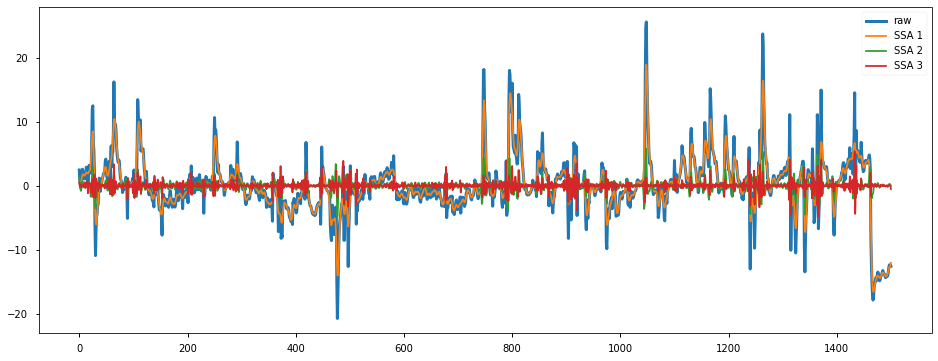

In [571]:
from cProfile import label


plt.figure(figsize=(16,6))
ax1=plt.subplot(111)
ax1.plot(ts.data,linewidth=3,label='raw')
#plt.xlim(300,450)
ax2=plt.subplot(111)
for i in range(np.shape(X_ssa)[0]):
    ax2.plot(X_ssa[i,:],label='SSA {0}'.format(i+1))
ax2.legend(loc='best')
#plt.xlim(300,450)

In [ ]:
res.isel(mode=0)

<xarray.Dataset>
Dimensions:  (time: 1501, z: 28375)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
  * z        (z) MultiIndex
  - Y        (z) float64 6.732e+06 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X        (z) float64 -4.124e+04 -4.119e+04 ... -3.219e+04 -3.214e+04
Data variables:
    U        (z) float32 -5.331e-11 -1.074e-13 6.134e-14 ... 0.0004857 0.0001407
    V        (z) float32 3.949e-11 6.703e-14 4.897e-17 ... -0.003026 -0.001298
    L        float32 3.316e+04
    A        (time) float32 10.33 8.738 3.418 -2.617 ... -13.59 -16.11 -17.61
    B        (time) float32 7.25 6.979 4.223 1.694 ... -13.5 -15.64 -15.87
    usvd     (time, z) float32 -1.058e-05 -6.445e-07 ... -0.0269 -0.007757
    vsvd     (time, z) float32 4.598e-07 -1.591e-07 ... 0.05575 -0.005245
    u        (time, z) float32 0.0 0.0 0.0 0.0 ... -0.04315 -0.02562 -0.007379
    v        (time, z) float32 0.0 0.0 0.0 0.0 ... 0.03503 0.03074 0.01637

<AxesSubplot:>

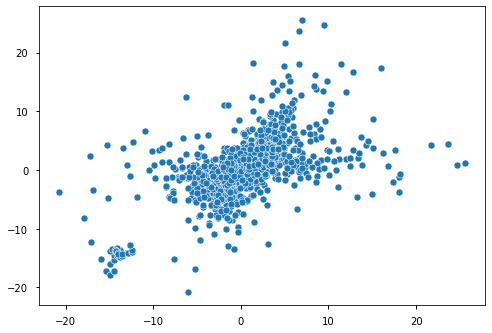

In [577]:
mode=0
sns.scatterplot(x=pcs.isel(mode=mode).A.data,y=pcs.isel(mode=mode).A.shift(time=4).data)

In [ ]:
from pyts.bag_of_words import BagOfWords
ts=res.A.isel(mode=0).data.reshape(1, -1)

bow=BagOfWords()
ts_bow=bow.transform(ts)


In [ ]:
from pyts.classification import LearningShapelets
clf=LearningShapelets()
clf.fit(ts)

TypeError: fit() missing 1 required positional argument: 'y'

In [ ]:
from pyts.approximation import DiscreteFourierTransform
dft=DiscreteFourierTransform(n_coefs=10)
ts_dft=dft.fit_transform(ts)

In [ ]:
ts_dft

array([[-9.76864249e-06, -7.80601785e+01,  2.94103783e+02,
        -9.90119212e+01, -5.26587478e+02, -9.55641453e+02,
        -4.56565238e+02, -4.94915414e+02, -2.92294210e+02,
         2.63048001e+02]])

## Wavelets

In [580]:
from collections import Counter
from pywt import wavedecn
import pywt
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=sp.stats.entropy(probabilities)
    return entropy
 
def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]
 
def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]
 
def get_features(list_values):
    entropy = calculate_entropy(list_values)
    #crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return  [entropy] + statistics #[entropy] + crossings + statistics

def pcs_to_features(xarr,modes=None, wavelet='db5',level=4):
    features = []
    
    if modes == None:
        modes=xarr.sizes['mode']
    length=xarr.sizes['time']
    print('length',length)
    print(pywt.dwt_max_level(length, wavelet))
    level=min(pywt.dwt_max_level(length, wavelet),level)
    for mode in range(0, modes):
        signal = xarr.isel(mode=mode)
        list_coeff = pywt.wavedec(signal,wavelet=wavelet, level=level)
        for coeff in list_coeff:
                features += get_features(coeff)
        features.append(features)
    
    return np.array(features)

def pick_random(xarr, length=124):
    max_start=xarr.sizes['time']-length
    start=randrange(0,100)#max_start)
    out=xarr.isel(time=slice(start,start+length))
    return out#, start

def get_features_n(data):
    #coeffs, axes, ndim, ndim_transform=pywt.coeffs_to_array(data,axes=0)
    features=[]
    for ii in range(1,len(data)):
        for jj in range(np.shape(data[ii]['d'])[1]):
       # print(ii,jj)
            features +=get_features(data[ii]['d'][:,jj])
    return features    

In [587]:
help(random.randint)

Help on method randint in module random:

randint(a, b) method of random.Random instance
    Return random integer in range [a, b], including both end points.



In [591]:

matrix=[]
start=[]
length=64
num=400
max_start=pcs.sizes['time']-length

starts=np.random.randint(0,max_start,num)


for start in starts:
    ts=pcs.A.isel(mode=slice(0,6)).isel(time=slice(start,start+length))
    tmp=wavedecn(ts.data,axes=0,wavelet='db8')
    tmp=get_features_n(tmp)
    #tmp=pywt.coeffs_to_array(tmp,axes=0)
    matrix.append(tmp)

matrix=np.asarray(matrix)
    

[ 762 1427 1061  771  650 1401  190  402  154  288  330  913   79  124
 1090 1318 1282  436  180  634  592  727  182  511 1433  491  338  297
  197  370   58  977  631  893  869  260 1333  109  743 1033  272  967
  365  818  802  703  103  173   69  655 1084  364 1073  463 1258  982
  194 1396  252  145 1073  565  987  703  732 1226  829 1377 1363 1259
   58  155  499  385   64  648    3  935  848   40  660  562  566 1006
   17  843 1302  244  567  746 1350  287  477 1243  203  480  871   84
 1208  939  477  744  574  675 1250  265 1275  261 1002   49 1413  609
  657  410  947  649  851 1130 1226 1006  666 1204  142  183 1160  282
 1170  554  365  830  547 1319  476 1089  938  187  969  339 1421  570
  510  490  135  986  274 1211  230  404  855 1021 1109  679  654   95
  600  773  635  346  196 1077 1267  223  424  828  728  571  756  916
 1062 1279  615 1143 1090  624 1331  441  631  686  161  261 1318  436
  492  897  789  720  534  644  384  733  464 1125  114  150 1017  304
 1002 

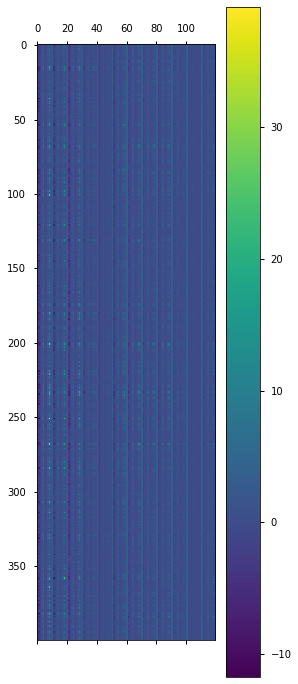

In [592]:
plt.matshow(matrix)
plt.colorbar()

In [593]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
#matrix= StandardScaler().fit_transform(matrix)
db = DBSCAN(eps=5, min_samples=3).fit(matrix)

In [594]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
# print(
#     "Adjusted Mutual Information: %0.3f"
#     % metrics.adjusted_mutual_info_score(labels_true, labels)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(matrix, labels))
labels

Estimated number of clusters: 4
Estimated number of noise points: 73
Silhouette Coefficient: 0.299


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,
       -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0, -1,
       -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0, -1,  0,  0, -1, -1,  0, -1,  0,  0, -1,  0,  0, -1,  0, -1, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1, -1,  0,  0,  0,  0, -1, -1,  0,  0, -1,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3, -1,  0, -1,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0,
       -1,  0,  0,  0,  0

In [ ]:

Counter(labels).most_common()

[(0, 355), (-1, 30), (1, 4), (2, 4), (3, 4), (4, 3)]

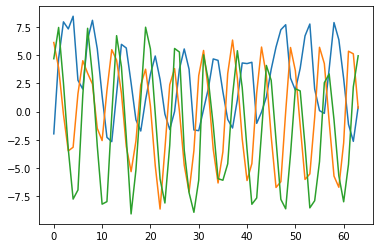

In [491]:
indx=np.where(labels==3)[0]
for ii in indx:
    plt.plot(pcs.A.isel(time=slice(ii,ii+length)).isel(mode=0).data)

In [528]:
(signal.time[-1]-signal.time[0])/np.timedelta64(1, 'h')

<xarray.DataArray 'time' ()>
array(2666.)

## Low pass filter

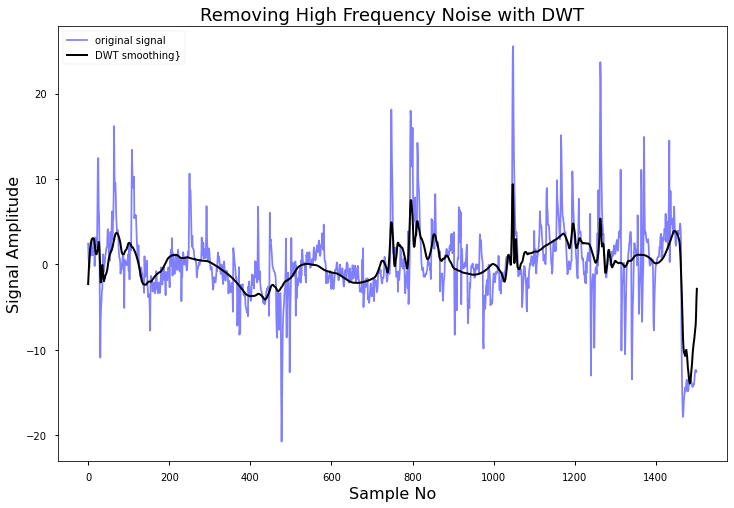

In [595]:
signal =pcs.A.isel(mode=0)
def lowpassfilter(signal, thresh = 0.63, wavelet="db4"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal
 
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(signal, color="b", alpha=0.5, label='original signal')
rec = lowpassfilter(signal, 0.5)
ax.plot(rec, 'k', label='DWT smoothing}', linewidth=2)
ax.legend()
ax.set_title('Removing High Frequency Noise with DWT', fontsize=18)
ax.set_ylabel('Signal Amplitude', fontsize=16)
ax.set_xlabel('Sample No', fontsize=16)
plt.show()

In [427]:
plt.plot(signal-rec)

ValueError: operands could not be broadcast together with shapes (1501,) (1502,) 

In [597]:
import pywt
time=pcs.time.data
dt=((time[1]-time[0]))/np.timedelta64(1, 'h')
dt

2.0

In [598]:

wavelet = 'haar'
scales = np.arange(4, 100)
f=pywt.scale2frequency('cmor0.5-1.0', 7)/dt
f


0.07142857142857142

In [599]:
pywt.frequency2scale('cmor0.5-1.0', 0.4/dt)

5.0

In [600]:
pcs.A.data

array([[  2.4378731 ,  -0.79466546,  -1.3120866 , ...,   0.7942919 ,
          0.8349379 ,   0.18781121],
       [  0.79398614,  -0.45878264,  -1.8212517 , ...,   0.7394221 ,
          0.26846692,   0.72680825],
       [  0.11738899,  -1.6204076 ,  -2.0795383 , ...,   0.04095164,
          0.39602718,   0.04412293],
       ...,
       [-12.361448  ,  -1.0636874 ,  -2.8880987 , ...,   0.41062805,
         -0.35053328,   0.15738997],
       [-12.372014  ,  -1.0137608 ,  -3.6103106 , ...,   0.44948596,
         -0.49289098,   0.7816257 ],
       [-12.592502  ,  -1.2552015 ,  -3.9685876 , ...,   0.8168655 ,
         -0.15520112,   0.40323952]], dtype=float32)

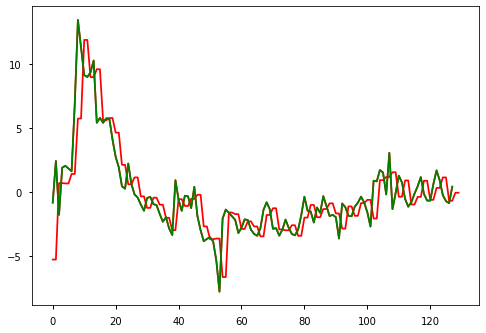

In [602]:
start=100
ts=pcs.A.sel(mode=0).isel(time=slice(start,start+128)).data
wavelet='haar'
(cA, cD) = pywt.dwt(ts, 'db2', 'smooth')
coeffs = pywt.wavedec(ts, wavelet=wavelet,level=4)

tsn=pywt.idwt(cA=cA,cD=None,wavelet='db1')
tst=pywt.downcoef('a', ts, wavelet, mode='symmetric', level=1)
# coeffs[1] = np.zeros_like(coeffs[1])
# coeffs[2] = np.zeros_like(coeffs[2])
# coeffs[3] = np.zeros_like(coeffs[3])
# coeffs[4] = np.zeros_like(coeffs[4])
# coeffs[0] = np.zeros_like(coeffs[0])
# coeffs[-1] = np.zeros_like(coeffs[-1])
tsm=pywt.waverec(coeffs, wavelet=wavelet)
plt.plot(ts,'r-')
plt.plot(tsn,'r-')
plt.plot(tsm,'g-')

In [79]:
np.shape(tst)

(64,)

In [80]:
features=[]
for coeff in coeffs:
    features += get_features(coeff)

np.shape(features)

(60,)

In [81]:
coeffs

[array([14.626402  ,  9.399781  ,  2.4899595 , -2.8686278 , -4.6038127 ,
        -1.01774   ,  0.8437772 , -0.64952195], dtype=float32),
 array([-1.8503838 , -0.6798792 ,  1.9629029 , -2.3485677 ,  0.02574635,
         3.99812   , -5.375926  ,  2.8259406 ], dtype=float32),
 array([-3.7089815 , -0.05212259,  6.489313  ,  3.2703483 , -5.290063  ,
         1.9534938 ,  6.49018   , -5.3101044 , -3.7541895 ,  7.4773436 ,
        -0.64559793, -7.866016  ,  4.995854  ,  5.352899  , -8.851614  ,
         1.714972  ], dtype=float32),
 array([  4.859575  ,  -3.9734812 ,   2.4698987 ,   6.2012906 ,
         -5.3227053 ,   2.0150633 ,   4.648406  ,  -6.947896  ,
          5.147896  ,   0.12326694,  -5.7159843 ,   7.3039236 ,
         -2.251917  ,  -6.2526503 ,   7.8802376 ,  -3.780116  ,
         -4.7378488 ,   8.919985  ,  -5.9397573 ,  -1.3669026 ,
          8.278688  ,  -8.00881   ,   1.4334893 ,   7.418462  ,
         -9.199635  ,   1.41398   ,   5.519459  , -10.822953  ,
          4.971225  ,

In [52]:
np.shape(np.vstack((features,ff)))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 9 and the array at index 1 has size 11

In [41]:
ff=features
ff

[0.0,
 0.0,
 0.6931471805599453,
 1.3862943611198906,
 2.0794415416798357,
 2.772588722239781,
 3.4657359027997265,
 4.1588830833596715,
 4.852030263919617,
 5.545177444479562,
 6.2383246250395095]

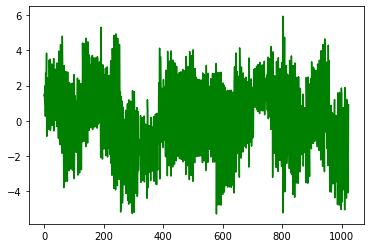

In [391]:
plt.plot(ts-tsm,'g-')

In [358]:
coeffs

[array([  7.702077, -39.524193], dtype=float32),
 array([1.3529294, 0.       ], dtype=float32),
 array([17.67728  , -5.5030026, 35.119217 ], dtype=float32),
 array([12.423834, 11.145011,  6.137113, 12.926641, -9.371059, 45.89005 ],
       dtype=float32),
 array([-9.244692  , -7.613444  , 12.155907  , -4.092545  ,  1.314383  ,
         3.5204852 ,  0.50240326, -0.06099248,  4.4025865 ,  9.700112  ,
        -8.065258  , 58.483543  ], dtype=float32),
 array([ 0.11671591, -2.1996813 ,  2.3194332 , -4.488669  ,  1.8944468 ,
         6.1045465 , -4.342495  , -3.2876828 , -1.7861972 , -1.9190127 ,
         3.7919388 , -5.5859995 , -9.247363  ,  3.7556865 ,  4.982523  ,
        -0.2893933 , 14.035786  , -0.96622944,  2.3058033 , -7.7224884 ,
         5.8117228 ,  3.401446  , 13.421504  ,  0.        ], dtype=float32),
 array([ 2.9629402 , -8.372102  ,  2.0933313 , -0.6259804 ,  6.779351  ,
         5.1551404 ,  1.5700674 , -7.7015476 , -5.6606603 ,  0.1762712 ,
         2.841128  ,  7.0274315 ,

In [603]:
arr=[]
for ii in np.arange(2):
    ts=pcs.A.sel(mode=0).isel(time=slice(100+ii*10,164+10*ii)).data
    (cA, cD) = pywt.dwt(ts, 'db2', 'smooth')
    arr.append(cD.T)

arr

[array([-1.1920929e-07, -2.8353865e+00,  6.3053620e-01, -2.6456423e+00,
         4.0343032e+00, -9.6658647e-01, -3.4390533e-01, -1.7780317e+00,
        -2.5563812e-01,  8.2345152e-01, -2.8877562e-01, -5.4353690e-01,
         1.4434934e+00, -3.7031424e-01,  4.0210783e-03,  2.4723485e-01,
        -1.4994359e-01,  3.9086513e-02,  4.6381429e-01, -2.3546383e+00,
         4.3302384e-01,  3.2555678e-01, -1.1333243e+00, -6.8989664e-02,
        -5.3455263e-01,  2.3006195e-01,  5.9457481e-01,  1.3647717e+00,
         1.3102520e-01,  3.6264786e-01, -2.9986843e-01,  4.2613280e-01,
        -2.3841858e-07], dtype=float32),
 array([ 0.0000000e+00, -3.4390533e-01, -1.7780317e+00, -2.5563812e-01,
         8.2345152e-01, -2.8877562e-01, -5.4353690e-01,  1.4434934e+00,
        -3.7031424e-01,  4.0210783e-03,  2.4723485e-01, -1.4994359e-01,
         3.9086513e-02,  4.6381429e-01, -2.3546383e+00,  4.3302384e-01,
         3.2555678e-01, -1.1333243e+00, -6.8989664e-02, -5.3455263e-01,
         2.3006195e-01,

In [604]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(pcs.A.data)
np.min(X)

-7.573921

In [605]:

db = DBSCAN(eps=1, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 0
Estimated number of noise points: 1501


NameError: name 'labels_true' is not defined

In [606]:
scales = np.logspace(0.01, 1.1, num=50)

#scales = np.arange(15,600, 4)
ax = scg.cws(date2num(res['time']), ts, scales, figsize=(12,6),ylabel="Period [Days]", xlabel='Year')#, yscale='log')
ax.set_yticks([0.2,0.5,0.6,1])
ax.set_yticklabels([0.2,0.5,0.6, 1,])

NameError: name 'scg' is not defined

In [58]:
sp.signal.cwt(ts,sp.signal.ricker,np.arange(1,31))

array([[ 4.25667161e+00,  1.09585968e+01,  2.75321683e+00, ...,
         2.62720317e+00, -3.26976690e+00, -9.63667427e+00],
       [ 9.56999583e+00,  1.03311946e+01,  1.94001797e+00, ...,
        -1.68749584e+00, -7.46110243e+00, -8.73994281e+00],
       [ 6.11540561e+00,  4.42372374e+00,  6.43564827e-01, ...,
        -7.09562219e+00, -7.15639266e+00, -5.36592839e+00],
       ...,
       [ 9.34275942e-02,  3.95756372e-02, -3.00189630e-02, ...,
        -3.66576230e+01, -3.43748544e+01, -3.20265524e+01],
       [-3.30755880e-01, -3.91706902e-01, -4.66019036e-01, ...,
        -3.77186057e+01, -3.55457904e+01, -3.33054635e+01],
       [-7.41666086e-01, -8.06459850e-01, -8.82489584e-01, ...,
        -3.86566239e+01, -3.65916967e+01, -3.44580426e+01]])

## Cross corr fine-coarse

In [ ]:
HRdata=surface.sel(Y=slice(6733400,6737500),X=slice(-40000,-35000))

Text(0.5, 1.0, 'Standard deviation v velocity')

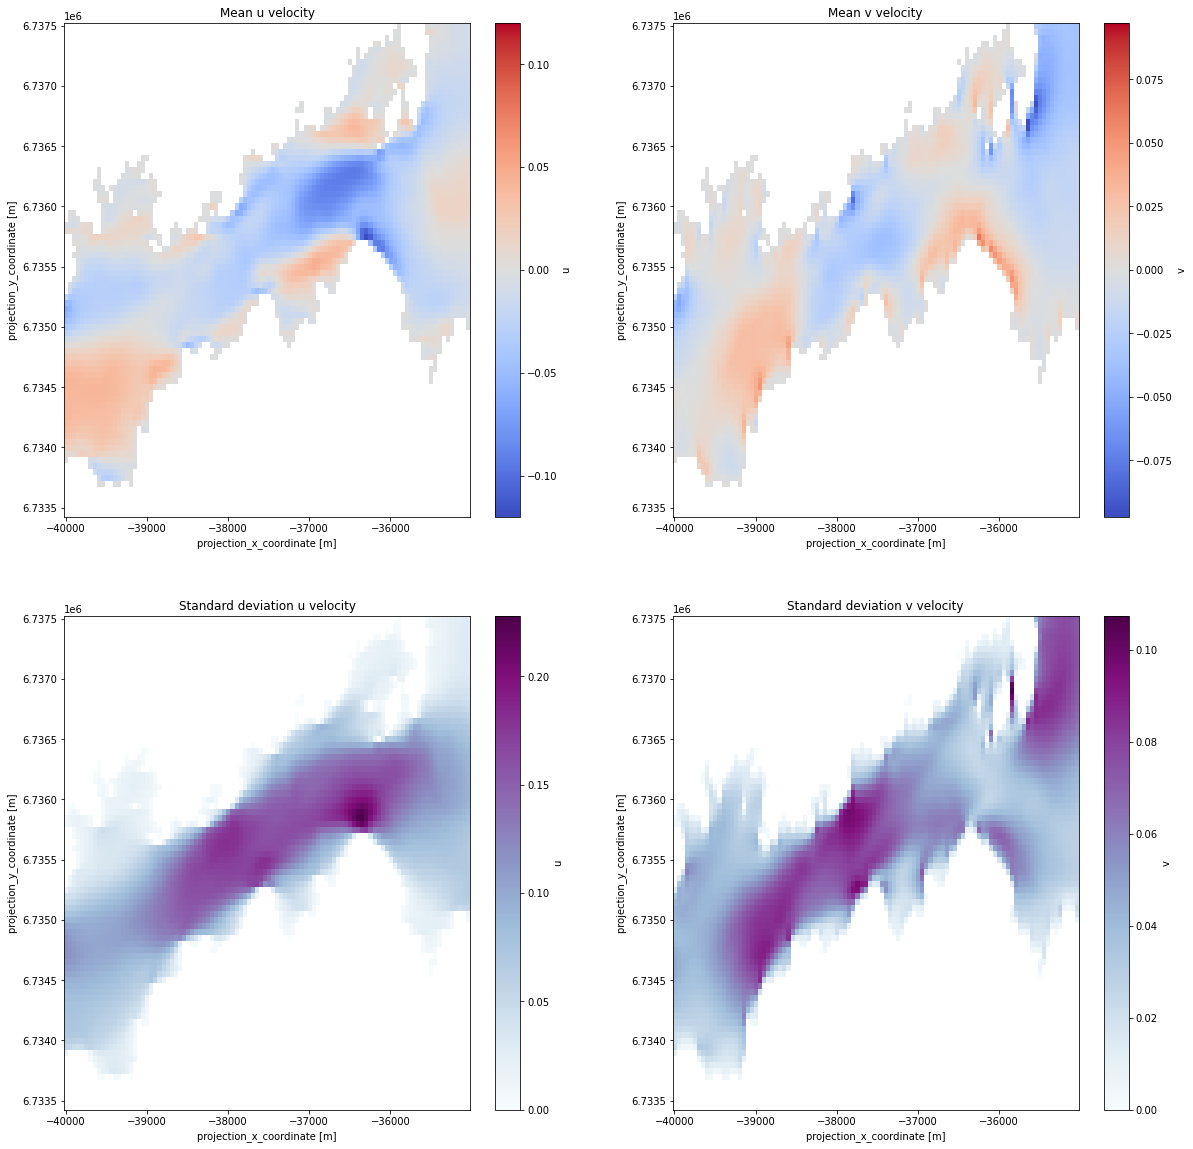

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
cmap='coolwarm'
cmap_std='BuPu'
HRdata.u.mean(dim='time').where(HRdata.land_binary_mask==0).plot(ax=axes[0,0],cmap=cmap)
axes[0,0].set_title('Mean u velocity')
HRdata.v.mean(dim='time').where(HRdata.land_binary_mask==0).plot(ax=axes[0,1],cmap=cmap)
axes[0,1].set_title('Mean v velocity')
HRdata.u.std(dim='time').where(HRdata.land_binary_mask==0).plot(ax=axes[1,0],cmap=cmap_std)
axes[1,0].set_title('Standard deviation u velocity')
HRdata.v.std(dim='time').where(HRdata.land_binary_mask==0).plot(ax=axes[1,1],cmap=cmap_std)
axes[1,1].set_title('Standard deviation v velocity')


In [ ]:
yname='Y'
xname='X'
skip=6
LRdata=HRdata.isel(Y=slice(0,HRdata.dims[yname],skip),X=slice(0,HRdata.dims[xname],skip))

Text(0.5, 1.0, 'Standard deviation v velocity')

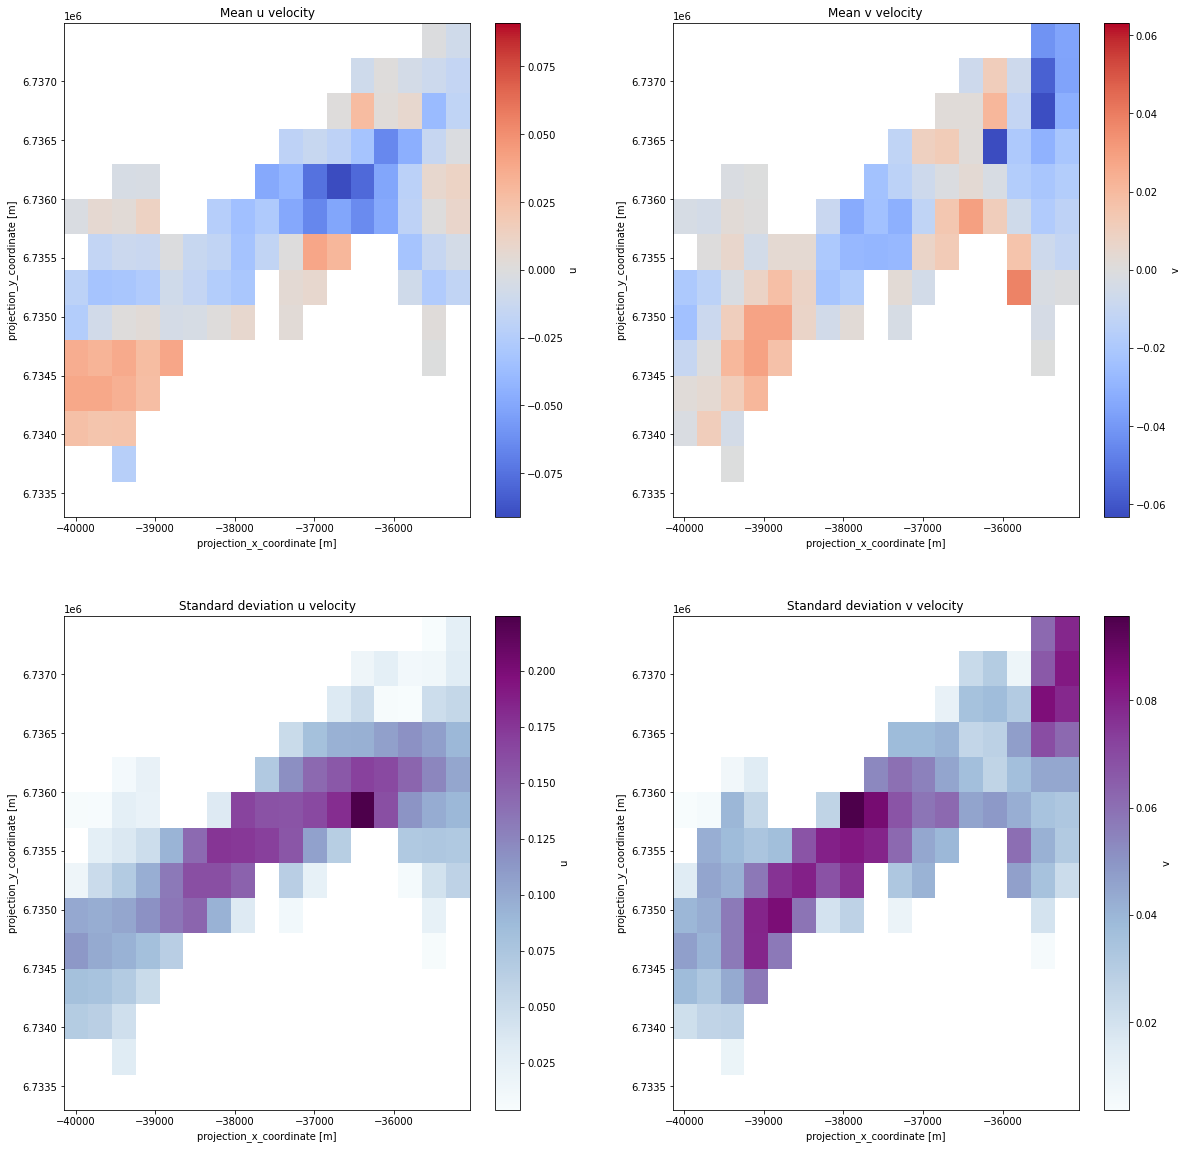

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
cmap='coolwarm'
cmap_std='BuPu'
LRdata.u.mean(dim='time').where(LRdata.land_binary_mask==0).plot(ax=axes[0,0],cmap=cmap)
axes[0,0].set_title('Mean u velocity')
LRdata.v.mean(dim='time').where(LRdata.land_binary_mask==0).plot(ax=axes[0,1],cmap=cmap)
axes[0,1].set_title('Mean v velocity')
LRdata.u.std(dim='time').where(LRdata.land_binary_mask==0).plot(ax=axes[1,0],cmap=cmap_std)
axes[1,0].set_title('Standard deviation u velocity')
LRdata.v.std(dim='time').where(LRdata.land_binary_mask==0).plot(ax=axes[1,1],cmap=cmap_std)
axes[1,1].set_title('Standard deviation v velocity')


In [ ]:
def create_vel(data):
    data['vel']=xr.concat([data['u'],data['v']] ,dim='comp')
    data=data.stack(z=['comp','Y','X'])
    data=data.where(data.land_binary_mask==0,drop=True).dropna(dim='time')
    return data

def norm_vel(data):
    out=((data-data.mean(dim='time')))#/data.std(dim='time'))
    return out.dropna(dim='z')
#LRvel=xr.concat([LRdata['u'],LRdata['v']] ,dim='comp')

In [ ]:
HRvel=create_vel(HRdata)['vel']
LRvel=create_vel(LRdata)['vel']

In [ ]:
HRnorm=norm_vel(HRvel)
LRnorm=norm_vel(LRvel)

In [ ]:
LRvel

<xarray.DataArray 'vel' (time: 1501, z: 196)>
array([[-0.0551476 ,  0.01174853,  0.03578741, ...,  0.08330455,
         0.04893956,  0.0587655 ],
       [-0.03705893,  0.00864483,  0.0177404 , ...,  0.02797446,
        -0.03271115,  0.01471524],
       [-0.04463166, -0.06056198, -0.04702141, ..., -0.08073766,
        -0.10956556, -0.05944214],
       ...,
       [-0.03264773, -0.06113115, -0.064557  , ..., -0.36713946,
        -0.24694295, -0.3555003 ],
       [-0.02868588,  0.03920212, -0.02433619, ..., -0.34373873,
        -0.24446808, -0.32651347],
       [-0.00799333,  0.16502129,  0.12401505, ..., -0.32733768,
        -0.21551655, -0.29502633]], dtype=float32)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
  * z        (z) MultiIndex
  - comp     (z) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
  - Y        (z) float64 6.734e+06 6.734e+06 6.734e+06 ... 6.737e+06 6.737e+06
  - X        (z) float64 -3.939e+04 -3.999e+04 ... -3.549e+04 -3.519e+04
Attributes:
    units:          meter second-1
    time:           ocean_time
    field:          u-velocity, scalar, series
    grid_mapping:   projection_stere
    long_name:      Sea water x velocity
    standard_name:  x_sea_water_velocity

In [ ]:
C=(1/1500)*HRnorm.data.T@LRnorm.data

In [ ]:
U,L,Vt = np.linalg.svd(C)
V=Vt.T

U=U[:,0:10]
V=V[:,0:10]
L=L[0:10]

In [ ]:
A=HRnorm.data@U
B=LRnorm.data@V

In [ ]:
uf=xr.DataArray(A@U.T,coords=HRnorm.coords)
vf=xr.DataArray(B@V.T,coords=LRnorm.coords)


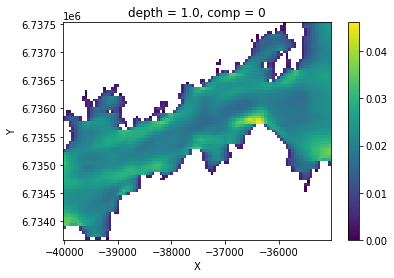

In [ ]:
(uf-HRnorm).std(dim='time').unstack('z').isel(comp=0).plot()

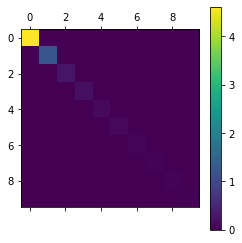

In [ ]:
plt.matshow((A-A.mean(axis=0)).T@(B-B.mean(axis=0))/1500)
plt.colorbar()

In [ ]:
U

array([[ 3.83895440e-06,  4.03594808e-04,  6.39574195e-04, ...,
         3.11101496e-04,  9.08863265e-04, -9.24636988e-05],
       [-6.21268964e-06,  4.16153111e-04,  6.70103298e-04, ...,
         2.99452571e-04,  8.01909948e-04, -1.09693676e-04],
       [ 2.53232865e-04,  2.28864650e-04, -1.06060717e-04, ...,
        -8.76659062e-04,  3.20902363e-05,  1.19864219e-03],
       ...,
       [-8.14827252e-03,  1.85044727e-03, -3.31741832e-02, ...,
         1.03231436e-02,  3.96297267e-03,  1.85171738e-02],
       [-7.98618887e-03,  2.50808639e-03, -3.10624707e-02, ...,
         8.11454374e-03,  5.49258804e-03,  2.06322763e-02],
       [-7.79969990e-03,  2.91161239e-03, -2.87246201e-02, ...,
         5.75634837e-03,  5.75837260e-03,  2.17000842e-02]], dtype=float32)